In [1]:
import numpy as np
import scipy
import time
import math
import itertools
from scipy.stats import norm

from copy import deepcopy

from tomography import *

from NestedForLoop import get_iterator
from pathlib import Path
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

import fnmatch
from efficiencies import *
from optimization import Optimizer, function_fidelity_U4, FidelityResults, function_fidelity_Rz
from constants import *

from densitymatrix import DensityMatrix, apply_unitary_to_dm
from pathlib import Path
import fnmatch

In [2]:
working_dir = os.getcwd()
working_dir_data = r"C:\Users\Experience\Desktop\Multipartite Entanglement Experiment\Data\QST"
file ="QST_GHZ_aqtime=100.0s_20241206183248"

In [3]:
######################################################################################################
#----- COUNTING THE FILES AND SAVING THEM IN AN ARRAY TO MAKES THE REST OF THE ANALYSIS EASIER -------
######################################################################################################

n_files=0
os.chdir(working_dir_data)

filenames = [i for i in glob.glob(file)]
filenames.sort(key=os.path.getmtime)

index_to_file = {}

for index, filename in enumerate(filenames):
    os.chdir(f"{working_dir_data}\\{filename}")
    filenames_aux=[i for i in glob.glob("counts*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        index_to_file[n_files] = f"{filename}\\{filenames_aux_second}"
        n_files+=1
os.chdir(working_dir)

print("Analyse Files: ", filenames_aux)
print(filenames)

Analyse Files:  ['counts']
['QST_GHZ_aqtime=100.0s_20241206183248']


In [4]:
#####################################################################
#---------------------- DEFINING PARAMS ----------------------------#
#####################################################################
os.chdir(working_dir)
qubit_number=4

## Defining the columns of the data file we want to use as data to reconstruct the density matrix (eg.: HH HV VH and VV basis)
BASIS_TO_CHANNEL={
    "HA": 1,
    "VA": 2,
    "HB": 3,
    "VB": 4,
    "HC": 5,
    "VC": 6,
    "HD": 7,
    "VD": 8,
    }

### Bell state ###
# eigenstates = [['HA','HB'],['HA','VB'],['VA','HB'],['VA','VB']]

### 4 qubits GHZ ###
eigenstates = [['HA','HB','HC','HD'],['HA','HB','HC','VD'],['HA','HB','VC','HD'],['HA','HB','VC','VD'],
               ['HA','VB','HC','HD'],['HA','VB','HC','VD'],['HA','VB','VC','HD'],['HA','VB','VC','VD'],
               ['VA','HB','HC','HD'],['VA','HB','HC','VD'],['VA','HB','VC','HD'],['VA','HB','VC','VD'],
               ['VA','VB','HC','HD'],['VA','VB','HC','VD'],['VA','VB','VC','HD'],['VA','VB','VC','VD']]

fold = four_fold=[[BASIS_TO_CHANNEL[eigenstates[i][j]] for j in range(qubit_number)] for i in range(len(eigenstates))]

In [5]:
datafile_channels = fold.copy()

for clicks in fold:
    not_in_clicks = list(set(range(1, 2*qubit_number+1)) - set(clicks))
    not_in_clicks.sort()
    for rep in range(1, len(not_in_clicks)+1):
        for combo in itertools.combinations(not_in_clicks, rep):
            new_clicks = clicks + list(combo)
            new_clicks.sort()
            datafile_channels.append(new_clicks)
            
datafile_channels = np.array(list(set(map(tuple, datafile_channels))), dtype=object)
first_order = list(map(len, datafile_channels)) 
order = np.lexsort((datafile_channels, first_order))
datafile_channels = list(datafile_channels[order])
datafile_channels = [list(t) for t in datafile_channels]

In [6]:
# single_channels_offset = 8
coincidences_columns = []

# double_emission_columns = []

for i, iter in enumerate(eigenstates):
    proj = [BASIS_TO_CHANNEL[iter[m]] for m in range(qubit_number)]
    coincidences_columns.append(datafile_channels.index(proj))
#     double_emission_columns.append([datafile_channels.index(d) for d in datafile_channels if set(proj).issubset(set(d))])
#     double_emission_columns[-1].remove(coincidences_columns[-1])

column_start = np.min(coincidences_columns)# + single_channels_offset
column_stop = np.max(coincidences_columns) + 1# + single_channels_offset
print("Coincidences column_start:", column_start,"; column_stop: ", column_stop)

column_start_5_emissions = 2**qubit_number
column_stop_5_emissions = 2**qubit_number*qubit_number + column_start_5_emissions

column_start_6_emissions = column_stop_5_emissions
column_stop_6_emissions =  column_stop_5_emissions + 64*3

print("Coincidences column_start:", column_start_5_emissions,"; column_stop: ", column_stop_5_emissions)
print("Coincidences column_start:", column_start_6_emissions,"; column_stop: ", column_stop_6_emissions)

# column_start_2_emissions = np.min(double_emission_columns)# + single_channels_offset + 4
# column_stop_2_emissions = np.max(double_emission_columns)# + single_channels_offset + 4
# print("Double emission column_start:", column_start_2_emissions, "; column_stop: ", column_stop_2_emissions)

Coincidences column_start: 0 ; column_stop:  16
Coincidences column_start: 16 ; column_stop:  80
Coincidences column_start: 80 ; column_stop:  272


In [7]:
# coincidences_columns

In [8]:
statetomo = []
state = []
state_file = []

xp_counts_corrected_with_eff=[]

#####################################################################
#---------------------- STATE TOMOGRAPHY ----------------------------
#####################################################################
for index in range(len(index_to_file)):
    os.chdir(f"{working_dir_data}\\{index_to_file[index]}\\")
    datafiles=[i for i in glob.glob("*")]
    
    ### Calculating the efficiencies of each detector
    efficiencies=get_channels_eff(datafiles, qubit_number, column_start, column_stop, os.getcwd())
    efficiencies_5_emissions=get_channels_eff(datafiles, qubit_number, column_start_5_emissions, column_stop_5_emissions, os.getcwd())
    efficiencies_6_emissions=get_channels_eff(datafiles, qubit_number, column_start_6_emissions, column_stop_6_emissions, os.getcwd())
   

    print("Channels efficiencies: ", efficiencies)
#     print("Channels efficiencies (5-fold): ", efficiencies_5_emissions)
#     print("Channels efficiencies (6-fold): ", efficiencies_6_emissions)

    ### Opening the data files and writing the data in counts_aux array
    counts_aux=set_raw_counts(datafiles, qubit_number, column_start, column_stop, os.getcwd())
    xp_counts=np.array(np.transpose(counts_aux))
    total_per_basis=np.sum(xp_counts, axis=1)
 
    counts_aux_5_emissions=set_raw_counts_double_emissions(datafiles, qubit_number, column_start_5_emissions, column_stop_5_emissions, os.getcwd())
    xp_counts_5_emissions=np.array(np.transpose(counts_aux_5_emissions))

    counts_aux_6_emissions=set_raw_counts_double_emissions(datafiles, qubit_number, column_start_6_emissions, column_stop_6_emissions, os.getcwd())
    xp_counts_6_emissions=np.array(np.transpose(counts_aux_6_emissions))

    statetomo.append(LRETomography(int(qubit_number), xp_counts, xp_counts_5_emissions,xp_counts_6_emissions))
    statetomo[-1].run(correct_eff=efficiencies)# ,correct_double_emission_eff=efficiencies_5_emissions,correct_double_emission=None, four_emission_eff=None,GHZ = True)
    xp_counts_corrected_with_eff.append(statetomo[-1].xp_counts)
        
    state.append(statetomo[-1])
    state_file.append(index_to_file[index])

Channels efficiencies:  [0.67288474 0.79147235 0.61492338 0.73684211 0.70286476 0.87475017
 0.73484344 0.88074617 0.751499   0.87608261 0.73484344 0.82345103
 0.84543638 1.         0.78614257 0.97868088]


c:\Users\Experience\Desktop\Multipartite Entanglement Experiment\Analysis_code\Tomography\efficiencies.py:173: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  counts_aux=counts[[tuple(indice)]]


In [9]:
######################################
#-- DEFINING THE TARGET GHZ STATE ---
######################################
bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

states=state
for index in range(len(states)):
     print(np.real(np.round(states[index].state.fidelity(bell),5)))

0.05101


In [10]:
##########################################################
#----- OPTIMIZATION OF MAX FIDELITY UP TO UNITARIES ------
##########################################################
states=state
fid=np.zeros((n_files))
optimized_matrix=np.zeros((n_files,2**qubit_number,2**qubit_number), dtype='complex')

guess=np.zeros(3*(qubit_number))
bounds=[(-np.pi,np.pi)]*3*(qubit_number)
results = []

opt=Optimizer(guess, function_fidelity_U4, results=FidelityResults)
for index in range(len(states)):
    result=opt.optimize(qubit_number,states[index].state, bell, bounds=bounds)
    results.append(result)

In [11]:
print(results[-1].u1)
print(results[-1].u2)
print(results[-1].u3)
print(results[-1].u4)

[[ 0.8234528 +0.56259885j  0.06999967-0.0225402j ]
 [-0.06999967-0.0225402j   0.8234528 -0.56259885j]]
[[-0.22732945-0.95592241j  0.16410186+0.08720236j]
 [-0.16410186+0.08720236j -0.22732945+0.95592241j]]
[[ 0.82434297+0.53329889j  0.18867697-0.02125947j]
 [-0.18867697-0.02125947j  0.82434297-0.53329889j]]
[[ 0.74001482-0.64305896j  0.15772342-0.11822252j]
 [-0.15772342-0.11822252j  0.74001482+0.64305896j]]


In [12]:
##########################################################
#------------ ERRORS Input with BELL STATE---------------#
##########################################################
error_runs=1

U=[]
bell_aux=[]
target_ini=[]

states=state
states_file=state_file
players=["Arya", "Bran", "Cersei", "Dany"]

for index in range(len(states)):
    target=bellmatrix
    U.append(results[index].u)
    target_ini.append(np.transpose(np.conjugate(U[-1]))@bellmatrix@U[-1]) 


    # states[index].calculate_fidelity_error(players, error_runs, opt, target, optimization=True, bounds=bounds)
    
    # print('file, fidelity, fidelity_mean, fidelity_std: ',
    #       states_file[index], np.round(states[index].state.fidelity(target_ini[-1]),5), -np.round(states[index].fidelity_mu,5),
    #       np.round(states[index].fidelity_std,6), '\n')

Filename - no unitary optimization:  QST_GHZ_aqtime=100.0s_20241206183248
Average Rate: (11.848395061728395 +/- 0.4292527437306661) Hz
Fidelity with no unitary correction = (0.05101+0j)%


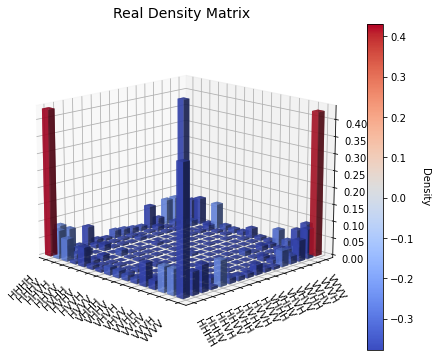

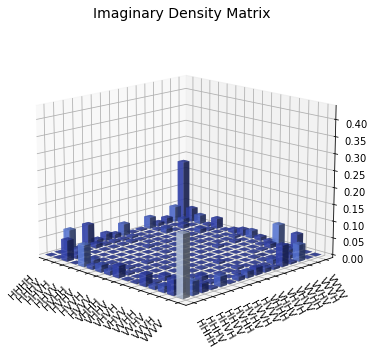

Filename - unitary optimization:  QST_GHZ_aqtime=100.0s_20241206183248
Filename:  QST_GHZ_aqtime=100.0s_20241206183248
Average Rate: (11.848395061728395 +/- 0.4292527437306661) Hz
Fidelity with unitary optimization = (0.95052+0j)%


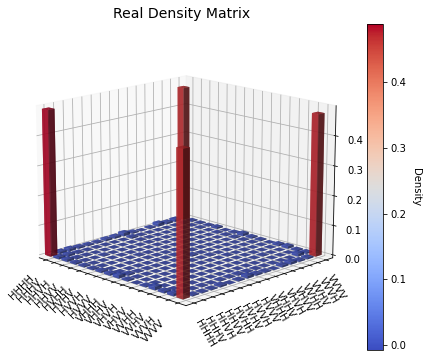

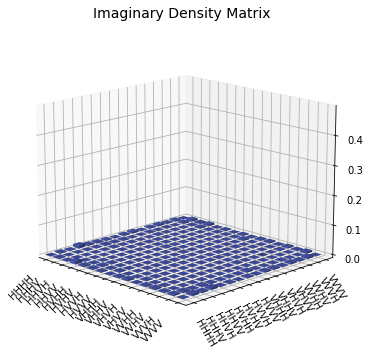

In [13]:
##########################################################
#--------------- PLOTTING DENSITY MATRIX-----------------#
##########################################################
print("Filename - no unitary optimization: ", file)
aq_time=100 #in seconds
print(f"Average Rate: ({np.average(total_per_basis)/aq_time} +/- {np.std(total_per_basis)/aq_time}) Hz")
print(f"Fidelity with no unitary correction = {np.round(states[-1].state.fidelity(bellmatrix),5)}%")
state[-1].state.plot_dm(cbar_real=True, cbar_im=False, save_pdf=None, save_svg=None)

print("Filename - unitary optimization: ", file)
print("Filename: ", file)

print(f"Average Rate: ({np.average(total_per_basis)/aq_time} +/- {np.std(total_per_basis)/aq_time}) Hz")
print(f"Fidelity with unitary optimization = {np.round(states[index].state.fidelity(target_ini[-1]),5)}%")
results[-1].optimized_state.plot_dm(cbar_real=True, cbar_im=False, save_pdf=None, save_svg=None)

In [ ]:
#### Everything under this line was used to analyse the quantum transmission certification

In [ ]:
##########################################################
#--------------- ERRORS OUTPUT TO INTPUT ----------------#
##########################################################
U=[]
bell_aux=[]
target_ini=[]

states=state_before

for index in range(len(states)):
    target=state_after[index]
    U.append(np.kron(results[index].u1,results[index].u2))
    target_ini.append(np.transpose(np.conjugate(U[-1]))@state_after[index].state.state@U[-1])
    
    states[index].calculate_fidelity_error_between_2_experimental_matrices(error_runs, players, target, apply_unitary_to_input=True)
    
    print('file, fidelity, fidelity_mean, fidelity_std: ',
          state_after_file[index], np.round(states[index].state.fidelity(target_ini[-1]),5), -np.round(states[index].fidelity_2_experimental_dms_mu,5),
          np.round(states[index].fidelity_2_experimental_dms_std,5), "\n")

In [ ]:
bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

result=opt.optimize(state_before[2].state, bell, bounds=bounds)
U[2]=np.kron(result.u1,result.u2)

t=state_after[2].state.state

t_ini=np.linalg.inv(U[2])@state_after[2].state.state@np.linalg.inv(np.transpose(np.conjugate(U[2])))

states[2].calculate_fidelity_error(players, error_runs, opt, t, bounds=bounds)

print('index, fidelity, fidelity_mean, fidelity_std: ',
        state_before_file[index], np.round(states[2].state.fidelity(t_ini),5), np.round(states[2].fidelity_mu,5),
        np.round(states[2].fidelity_std,5))

In [ ]:
##########################################################
#------------ ERRORS OUTPUT with BELL STATE--------------#
##########################################################
bell=(np.array([0,1,0,0])+np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))
error_runs=1

U=[]
bell_aux=[]
target_ini=[]

states=state_after
players=["Arya", "Cersei"]

guess=np.array([0, 0, 0])
bounds=[(-np.pi,np.pi)]*3
opt=Optimizer(guess, function_fidelity_Rz, results=FidelityResults)

for index in range(len(states)):
    target=bellmatrix
    #U.append(results[index].u)
    #target_ini.append(np.transpose(np.conjugate(U[-1]))@bellmatrix@U[-1])    
    
    states[index].calculate_fidelity_error(players, error_runs, opt, target, bounds=bounds)
    
    print('index, fidelity, fidelity_mean, fidelity_std: ',
          state_after_file[index], np.round(states[index].state.fidelity(target),5), np.round(states[index].fidelity_mu,5),
          np.round(states[index].fidelity_std,5))

In [ ]:
bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))
target=bellmatrix

result=opt.optimize(state_before[2].state, bell, bounds=bounds)

t=state_after[2].state.state

states[2].calculate_fidelity_error(players, error_runs, opt, t, bounds=bounds)

print('index, fidelity, fidelity_mean, fidelity_std: ',
        state_after_file[index], np.round(states[2].state.fidelity(target),5), np.round(states[2].fidelity_mu,5),
        np.round(states[2].fidelity_std,5))

In [ ]:
##########################################################
#------------ WRITING THE DATA IN AN EXCEL ---------------
##########################################################

import xlsxwriter
states=state_before

workbook = xlsxwriter.Workbook('fidelities_to_ini_state_errors.xlsx') ### We should write this in another place
 
worksheet = workbook.add_worksheet()

worksheet.write('A1', 'Number')
worksheet.write('B1', 'Folder')
worksheet.write('C1', 'Fidelity')
worksheet.write('D1', 'Fidelity_mean')
worksheet.write('E1', 'Fidelity_uncertainty')

counter=0
for index in range(len(state_before)):
    
    worksheet.write('A'+str(counter+2), counter)
    worksheet.write('B'+str(counter+2), state_before_file[index])
    worksheet.write('C'+str(counter+2), np.real(np.round(states_final[index].fidelity(target[index]),5)))#np.round(states[index].fidelity_to_pure(bell),5)))
    worksheet.write('D'+str(counter+2), np.real(np.round(states_final[index].mu,5)))
    worksheet.write('E'+str(counter+2), np.real(np.round(states_final[index].std,5)))
    counter+=1
        
workbook.close()

In [ ]:
### IF WE WANT TO CHECK THE FIT TO THE UNCERTARTAINTY
### Then we need to calculate the statistic on these simulated fidelities and calculate the standart deviation
### This will be our uncertainty due to statistical errors
def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(fidelity_sim)
#print(counted)
bin_numb = len(counted)
errorbar_x=np.array(list(counted))
errorbar_y=np.zeros((bin_numb), dtype=int)

for i in range(bin_numb):
    errorbar_y[i]=counted[errorbar_x[i]]
    
#print(errorbar_x)
#print(errorbar_y)
    
def Gauss(x, A, mu, sigm):
    y = A*np.exp(-((x-mu)/sigm)**2/2)
    return y

mu, std = norm.fit(fidelity_sim)
print(mu, std)
parameters, covariance = curve_fit(Gauss, xdata=errorbar_x[-1], ydata=errorbar_y[:-1], bounds=[(0,0.99007,1e-4),(60,0.9903,0.0002)])
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
print(fit_A, fit_B, fit_C)

xdata= x = np.linspace(0.989, 0.991, 100)
fit_y = Gauss(xdata, fit_A, fit_B, fit_C)
plt.plot(errorbar_x[:-1], errorbar_y[:-1], 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

In [ ]:
### This was to analyse the quantum channel certification paper
# state_after=[]
# state_after_file=[]

# state_before=[]
# state_before_file=[]

## The 'e' and 'r' serve to distinguish between tomography before and after, respectively
    ## We want to save them in different arrays because we need them for different things
#     elif index_to_file[index][-8]=='e':
#         state_before.append(statetomo[-1])#.state)
#         state_before_file.append(index_to_file[index])
#         #print('\n Fast maximum likelihood estimation: \n', state_before[-1], '\n')

#     elif index_to_file[index][-8]=='r':
#         state_after.append(statetomo[-1])#.state)
#         state_after_file.append(index_to_file[index])
#         #print('\n Fast maximum likelihood estimation: \n', state_after[-1], '\n')